<a href="https://colab.research.google.com/github/MarshaGomez/F5-MOEA-Variations/blob/main/examples/Single_Objective_Brachistochrone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Single Objective. Brachistochrone Problem


The Brachistochone is the famous problem to find the shape of the curve down wich a bead sliding from rest and accelerated by gravity will slip (**without friction**) from one point to another in the least time. 

"The shortest path and the shortest time"

## Base Operations

### Necessary libraries

In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True) 

Mounted at /content/gdrive


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as mplcm
import matplotlib.colors as colors
import random as rm
import os
import subprocess
import torch
import sys
import torch.optim as optim
import glob
import time

from pathlib import Path
from PIL import Image, ImageSequence
from time import sleep
from datetime import datetime, date
from math import sqrt,sin,cos, floor
from scipy.optimize import fsolve
from random import shuffle, randint, sample
from copy import deepcopy

### Global Values

In [3]:
base_path = "/content/gdrive/My Drive/Brachistochrone/MOEA Project/Single-Objective"
counter = 0

date_string = date.today()
base_name = f'GD_Brach__{date_string}'
gif_dir = os.path.join(base_path, "gifs/" + base_name)
misc_runs_dir = os.path.join(base_path, "misc_runs/" + base_name)

Path(gif_dir).mkdir(parents=True, exist_ok=True)
Path(misc_runs_dir).mkdir(parents=True, exist_ok=True)

### Hyperparameters

In [34]:
objectives = ["Short Time"]
n_dimensions = 1
n_iterations = 200
n_individuals = 40
n_generations = 400
n_points = 30

# Probabilities
ps = 0.2 # selection
pc = 1 # crossover
pm = 0.1 # mutation

elitismo = 0.1 

p_variable = True # Varied the probability


# Boundaries 
xl = 0 # left boundary
xr = 1 # rigth boundary
yu = 1 # up boundary
yl = -1 # low boundary
limits = [xl, yl]
weights = [0.1, 0.1]
height = 1
width = 1

seed = 1

show_info = True # See Description Prints
save_gif = True # Save gif image
frames_gif = 100
parents = []
new_individuals = []

### Common Functions

In [27]:
def normalize(data, min, max):
  normal = []
  old_min = np.min(data)
  old_max = np.max(data)
  old_range = old_max - old_min
  
  new_min = min
  new_max = max
  new_range = new_max - new_min

  if old_range == 0:            
      if old_min < new_min:      
          new_value = new_min
      elif old_min > new_max:    
          new_value = new_max
      else:                    
          new_value = old_min
      normal = [new_value for value in data]
  else:
      scale = new_range / old_range
      normal = [(value - old_min) * scale + new_min for value in data]

  return normal

def makeImage(fp_in, fp_out):
  global counter
  counter += 1
  imgs = (Image.open(f) for f in sorted(glob.glob(fp_in)))
  img = next(imgs)  # extract first image from iterator
  img.save(fp=fp_out, format='GIF', append_images=imgs,
          save_all=True, duration=400, loop=0)
  
  img = Image.open(fp_out)
  
def showGif(fname):
    import base64
    from IPython import display
    with open(fname, 'rb') as fd:
        b64 = base64.b64encode(fd.read()).decode('ascii')
    return display.HTML(f'<img src="data:image/gif;base64,{b64}" />')

def fitnessFunction(y_no_end_pts, height):
    g = 9.8
    n_segments = len(y_no_end_pts) + 1
    width = 1.0
    delta_x = width/n_segments
    #So if the next point is lower than the previous one, d will be *positive* (i.e., the y axis is down, opposite with the plot axis.)

    y = torch.cat((torch.tensor([height]), y_no_end_pts, torch.tensor([0.0])), dim=0)

    d = torch.stack([-(y[i+1] - y[i]) for i in range(n_segments)])

    temp = torch.stack([torch.tensor(0.0)] + [sum(d[:(i+1)]) for i in range(len(d))])
    v = sqrt(2*g)*torch.sqrt(temp)

    v = v[:-1]
    t = (torch.sqrt(v**2 + 2*g*d) - v)/(g*d/torch.sqrt(d**2 + delta_x**2))

    return(sum(t))



## Genetic Algorithm Components



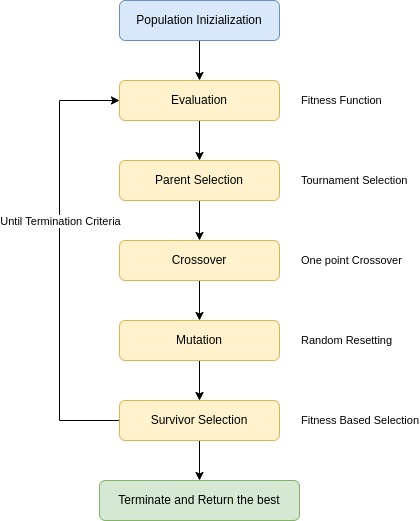

### Initialization


#### Individual

Creating Random Individual

In [15]:
class Individual():

  def __init__(self, n_points=n_points, height=height, **kwargs):
    self.n_segments = n_points
    self.n_points = n_points+1
    self.width = 1.0
    self.height = height
    self.y = [self.height]
    self.x = [0]
    self.delta_x = self.width/self.n_segments

    for i in range(self.n_segments-1):
        self.x.append((i+1)*self.delta_x)
        frac = 1
        self.y.append(-self.height/frac + rm.random()*(self.height - (-self.height/frac)))

    self.x.append(1.0)
    self.y.append(0)

    self.sol = None

    #This is just assuming it dropping vertically and then going horizonally at that speed
    g = 9.8
    t1 = sqrt(2*self.height/g)
    v1 = g*t1
    t2 = self.width/v1
    self.max_FF = 40*(t1 + t2)

#### Population

Creating a Population with n-random Individuals

In [7]:
class Population():
  
  def __init__(self, individual_class=Individual, n_individuals=n_individuals, **kwargs):
    self.kwargs_str = '__'.join(['{}={}'.format(x[0], x[1]) for x in kwargs.items()])
    print(self.kwargs_str)

    self.individual_class = individual_class
    self.class_name = individual_class.__name__
    self.n_individuals = n_individuals
    self.population = [[self.createNewIndivid(**kwargs), 0] for i in range(self.n_individuals)]
    self.sorted_population = None

    if (show_info):
      self.printPopulation()
      self.plotPopulation()

  def createNewIndivid(self, **kwargs):
    return(self.individual_class(**kwargs))

  def printPopulation(self):
    print("Population Edited Parameters: ")
    print(self.kwargs_str)
    print("--------------------------------")

  def plotPopulation(self,  **kwargs):
    print("Population Diagram: ")
    print("--------------------------------")
    # plot lines
    for individual in self.population:
      plt.plot(individual[0].x, individual[0].y)
    plt.show()


  

### Evaluation

In [37]:
class Fitness():

  global show_info

  def __init__(self, population=Population, **kwargs):
    self.population = deepcopy(population)

  def __del__(self):
    print("Destructor called")

  def getBestCurve(self, individual):
    w = individual.width
    h = individual.height

    #The coords we've been using (dropped at (0,h), ending at (w,0)), simply add h to y in the end.

    f_t = lambda t: np.cos(t)-1+ (-h/w)*(np.sin(t)-t)
    t = fsolve(f_t,3.14)[0]

    a = w/(t-sin(t))

    t_range = np.linspace(0,t,individual.n_points)

    x = lambda t: a*(t-np.sin(t))
    y = lambda t: h + a*(np.cos(t)-1)

    self.sol = (t_range, x, y)

    sol_numeric_y = []

    for x_pt in individual.x:
        f = lambda t: x(t)-x_pt
        tval = fsolve(f,3.14)[0]
        sol_numeric_y.append(y(tval))

    temp_state = individual.y
    individual.y = sol_numeric_y
    individual.sol_numeric_y = sol_numeric_y
    
    self.t_ideal = self.getFitness(individual)
    individual.y = temp_state

    if show_info:
      print('\n-------------------------------------')
      print('Theoretical best time:', self.t_ideal, "\n")

  def getFitness(self, individual):
    g = 9.8

    #So if the next point is lower than the previous one, d will be *positive* (i.e., the y axis is down, opposite with the plot axis.)
    d = -np.array([individual.y[i+1] - individual.y[i] for i in range(individual.n_segments)])

    #Be careful with signs and indices!
    v = sqrt(2*g)*np.sqrt([0] + [sum(d[:(i+1)]) for i in range(len(d))])

    if np.isnan(v).any():
      print('\n\nbad v:',v)
      print('\nbad d sum:',[sum(d[:(i+1)]) for i in range(len(d))])
      print('\nstate', individual.y)
      plt.savefig('test_bad_np.png')
      exit(0)


    #v = np.sqrt([0] + [sum(d[:(i+1)]) for i in range(len(d))])
    v = v[:-1]
    t = (np.sqrt(v**2 + 2*g*d) - v)/(g*d/np.sqrt(d**2 + individual.delta_x**2))

    F1 = (sum(t))
    return F1

  def getFitnessPopulation(self, sort=False):
    for individual in self.population.population:
      individual[1] = self.getFitness(individual[0])

    if sort:
      self.sortIndividuals()

    if show_info:
      self.printFitnessFunctions()

  def sortIndividuals(self):
    list.sort(self.population.population, key=lambda fitness: fitness[1])

  def printFitnessFunctions(self):
    print('\n-------------------------------------')
    print('Objective Fitness 1: ', objectives[0])
    print('\n')
    for index, individual in enumerate(self.population.population):
      print('Individual {:10}     |    Fitness: {:.4f}'.format(index, individual[1]))

  def plotState(self, individual, ax, width, height, color='black', plot_sol=False, plot_label=False):
    # Pass this an axis from another program. It will handle showing it and stuff.
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_title('Comparison Actual Result with Brachistochrone')

    if plot_sol:
      t = self.sol[0]
      x = self.sol[1]
      y = self.sol[2]
      ax.plot(x(t), y(t), '-', color='gray')

      if plot_label:
        ax.text(0.8*width, 0.9*height, 'ideal: {:.3f}'.format(self.t_ideal))

    if plot_label:
      ax.text(0.8*width, 0.8*height, 'cur. best: {:.3f}'.format(self.getFitness(individual)))

    ax.plot(individual.x, individual.y, 'o-', color=color)


  def plotFitnessFunction(self, ax, best, mean):
    ax.clear()
    ax.set_xlabel('Generations')
    ax.set_ylabel('Fitness Function')
    ax.set_title('Best and Mean Results')

    ax.plot(best, label='best', color='dodgerblue')
    ax.plot(mean, label='mean', color='tomato')
    ax.legend()
    ax.text(0.6*len(best), 0.8*max(best), 'best: {:.3f}\nmean: {:.3f}'.format(best[-1], mean[-1]))


### Selection

In [38]:
class Selection():
  
  def __init__(self, population=Population, ps=ps, **kwargs):
    self.population = population
    self.parents = []
    self.ps = ps
    self.quantity_parents = 3

  def __del__(self):
    print("Destructor called")

  # Probabilistic Selection
  def getProbabilisticSelection(self):
    probability = np.random.uniform(
        low=0, high=1, size=self.population.n_individuals)
    
    probability = probability < self.ps
    if sum(probability == True) > 0:
      self.quantity_parents = sum(probability == True)

  def getParentsSelection(self):
    self.getProbabilisticSelection()
    for i in range(self.quantity_parents):
      self.parents.append(self.tournamentSelection())

    # self.parents = np.unique(self.parents, axis=0)

    if show_info:
      self.printParents()

  def tournamentSelection(self):
    parents = rm.choices(self.population.population, k=5)
    list.sort(parents, key=lambda fitness: fitness[1])

    return (parents[0])

  def printParents(self):
    print('\n-------------------------------------')
    print('Selection Parents')
    print('\n')
    for index, individual in enumerate(self.parents):
      print('Individual {:10}     |    Fitness: {:.4f}'.format(index, individual[1]))

  def getBestAndMean(self):
    if self.sorted_population is None:
      return((0,0))

    best = self.sorted_population[0][1]
    mean = sum([individfitness[1] for individfitness in self.sorted_population])/(1.0*len(self.population))
    return((best,mean))

  def isSameState(self, other_state):
    max_diff = ((self.n_points-2)*self.height)**2
    diff = (np.array(self.y) - np.array(other_state.y))[1:-1]
    abs_diff_normed = abs(sum(diff))/(self.n_points-2)
    
    if abs_diff_normed < self.sameness_thresh:
      return(True)
    else:
      return(False)

  def deleteDuplicates(self,pop):
    unique_individuals = []
    no_duplicates = []
    
    for index,individual in enumerate(pop):
      is_not_unique = np.any([individual.isSameState(other) for other in no_duplicates])
      if not is_not_unique:
        unique_individuals.append(individual.y)
        no_duplicates.append(individual)

    return(no_duplicates)

### Crossover

In [39]:
class Crossover():
  
  def __init__(self, population=Population, parents=parents, pc=pc, **kwargs):
    self.population = population
    self.parents = parents
    self.new_individuals = []
    self.pc = pc

  def __del__(self):
    print("Destructor called")

  def getNewPopulation(self):
    rm.shuffle(self.parents)
    n_couple = int((len(self.parents)-1) / 2)
    for i in range(n_couple+1):
      new_child1, new_child2 = self.onePointCrossover(self.parents[i], self.parents[-i-1])
      self.new_individuals.append(new_child1)
      self.new_individuals.append(new_child2)

    if show_info:
      self.printNewPopulation()

  def onePointCrossover(self, parent1, parent2):
    new_child1 = deepcopy(parent1)
    new_child2 = deepcopy(parent2)

    r1 = randint(1,parent1[0].n_points-3)
    r2 = randint(r1+1,parent2[0].n_points-2)

    temp = new_child1[0].y[r1:r2]
    new_child1[0].y[r1:r2] = new_child2[0].y[r1:r2]
    new_child2[0].y[r1:r2] = temp

    return(new_child1, new_child2)


  def printNewPopulation(self):
    print('\n-------------------------------------')
    print('Crossover New Individuals')
    print('\n')
    for index, individual in enumerate(self.new_individuals):
      print('Individual {:10}     |    Fitness: {:.4f}'.format(index, individual[1]))


  def mateAvg(self,other_individ):
    newindivid_1 = deepcopy(self)
    newindivid_2 = deepcopy(other_individ)

    newindivid_1.y = ((np.array(newindivid_1.y) + np.array(newindivid_2.y))/2).tolist()

    return(newindivid_1,newindivid_1)

### Mutation

In [40]:
class Mutation():

  def __init__(self, new_individuals=new_individuals, pm=pm, **kwargs):
    self.new_individuals = new_individuals
    self.pm = pm

  def __del__(self):
    print("Destructor called")
    
  def randomSetMutation(self):
    new_individual = []
    new_individual.clear()

    height = 1

    for individual in self.new_individuals:
      # ****
      height = individual[0].height

      probability = np.random.uniform(
      low=0, high=1, size=individual[0].n_points-2)
    
      probability = probability < pm
      if sum(probability == True) > 0:
          individual[0].y = individual[0].y[1: individual[0].n_points-1]

          # Muta Random Process
          mutate_individual = deepcopy(individual[0])
          for i in np.where(probability)[0]:
              frac = 2
              mutate_individual.y[i] = (-height/frac + rm.random()*(height - (-height/frac)))

      new_individual = [height] + mutate_individual.y + [0]

      individual[0].y = new_individual

      if show_info:
        self.printMutation()

  def printMutation(self):
    print('\n-------------------------------------')
    print('Crossover New Individuals')
    print('\n')
    for index, individual in enumerate(self.new_individuals):
      print('Individual {:10}     |    Fitness: {:.4f}'.format(index, individual[1]))

  def mutateSingle(self):
    index = randint(1, self.n_segments-1)
    new_height = self.y[index] + np.random.normal(scale=self.mutate_strength)
    
    if new_height < self.height:
      self.y[index] = new_height

### Survivor Selection

In [41]:
class Survivor_Selection():
  def __init__(self, population=Population, new_individuals=new_individuals, **kwargs):
    self.population = population
    self.new_individuals = new_individuals
    self.new_population = []

  def __del__(self):
    print("Destructor called")

  def getNewPopulation(self):
    
    for individual in self.new_individuals:
      #individual[1] = self.getFitness(individual[0])
      print(individual[1])
      print(individual)
      print(self.getFitness(individual[0]))

    self.new_population = self.population.population + self.new_individuals
    
    list.sort(self.new_population, key=lambda fitness: fitness[1])
    
    self.new_population = self.new_population[: self.population.n_individuals]
    self.population.population = self.new_population

    if show_info:
      self.printSurvivor()

  def getFitness(self, individual):
    g = 9.8

    #So if the next point is lower than the previous one, d will be *positive* (i.e., the y axis is down, opposite with the plot axis.)
    d = -np.array([individual.y[i+1] - individual.y[i] for i in range(individual.n_segments)])

    #Be careful with signs and indices!
    v = sqrt(2*g)*np.sqrt([0] + [sum(d[:(i+1)]) for i in range(len(d))])

    if np.isnan(v).any():
      print('\n\nbad v:',v)
      print('\nbad d sum:',[sum(d[:(i+1)]) for i in range(len(d))])
      print('\nstate', individual.y)
      plt.savefig('test_bad_np.png')
      exit(0)


    #v = np.sqrt([0] + [sum(d[:(i+1)]) for i in range(len(d))])
    v = v[:-1]
    t = (np.sqrt(v**2 + 2*g*d) - v)/(g*d/np.sqrt(d**2 + individual.delta_x**2))

    F1 = (sum(t))
    return F1

  def printSurvivor(self):
    print('\n-------------------------------------')
    print('Objective Fitness 1: ', objectives[0])
    print('\n')
    for index, individual in enumerate(self.population.population):
      print('Individual {:10}     |    Fitness: {:.4f}'.format(index, individual[1]))



## Genetic Algorithm execution

In [42]:
class GeneticAlgorithm():

  # Variable = Variation of the Probability between epochs
  def __init__(self, population=Population, generations=n_generations, variable=p_variable):
    self.n_generations = n_generations 
    self.p_variable = p_variable

    start = time.time()

    fitness = Fitness(population)
    fitness.getFitnessPopulation()

    selection = Selection(population, ps)
    selection.getParentsSelection()

    crossover = Crossover(population, selection.parents, pc)
    crossover.getNewPopulation()

    mutation = Mutation(crossover.new_individuals, pm)
    mutation.randomSetMutation()

    survivor_selection = Survivor_Selection(population, mutation.new_individuals)
    survivor_selection.getNewPopulation()


    end = time.time()

    if show_info:
      print("\n-------------------------------------------")
      print("Process Complete ")
      print("\n")
      print("Time Process: {:20}".format(str(end - start)))
      print("\n-------------------------------------------\n")

    
    

    '''
    def plot_evolution(self,  **kwargs):
      N_gen = kwargs.get('N_gen', 550)
      plot_state = kwargs.get('plot_state', True)
      plot_whole_pop = kwargs.get('plot_whole_pop', False)
      save_best_FF = kwargs.get('save_best_FF', True)

      base_name_temp = f'evolve_{self.class_name}__pop={self.n_individuals}__gen={N_gen}__{self.kwargs_str}__{date_string}'

      if save_gif:
          N_gif_frames = 100
          gif_dir = os.path.join(base_path, "gifs/" + base_name_temp)
          Path(gif_dir).mkdir(parents=True, exist_ok=True)

      if plot_state:
          fig, axes = plt.subplots(2,1,figsize=(6,8))
          ax_FF = axes[0]
          ax_state = axes[1]
      else:
          fig, ax_FF = plt.subplots(1,1,figsize=(8,8))

      if show_info:
          plt.show(block=False)

      sol_found = False

      best = []
      mean = []
      cur_best, cur_mean = 0, 0

      method_list = [func for func in dir(self.individ_class) if callable(getattr(self.individ_class, func))]

      if plot_state and plot_whole_pop:
          NUM_COLORS = self.n_population + 2
          cm = plt.get_cmap('RdBu')
          cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
          scalar_map = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
          pop_plot_color_list = [scalar_map.to_rgba(i) for i in range(NUM_COLORS)][::-1]


      for i in range(self.generations):
          self.sortIndivids()
          cur_best, cur_mean = self.getBestAndMean()

          best.append(cur_best)
          mean.append(cur_mean)

          if i%max(1, int(N_gen/20.0))==0:
              print('Generation {}, current best = {:.3f}, current pop. size = {}'.format(i, cur_best, len(self.population)))

          if 'solFound' in method_list:
              if self.population[0].solFound():
                  print(f'found solution in generation {i}!\n')
                  if 'printState' in method_list:
                      self.population[0].printState()
                  break

          # Plot the current best and mean.
          self.plotFitnessFunction(ax_FF, best, mean)

          # If we're plotting the state of the population, call their plotState() functions.
          # You can plot either the best member, or the whole pop.
          if plot_state:
              ax_state.clear()

              if plot_whole_pop:
                  for j, ind in enumerate(self.population[::-1]):
                      ind.plotState(ax_state, color=pop_plot_color_list[j])

              self.population[0].plotState(ax_state, color='black', plot_sol=True, plot_label=True)

          if show_info:
              fig.canvas.draw()

          if save_gif:
              if i==0 or (i%max(1, int(N_gen/N_gif_frames))==0):
                  plt.savefig(f'{gif_dir}/{i+1}.png')

          self.mateGrid()



      plt.savefig(f'{misc_runs_dir}/{base_name_temp}.png')

      if save_best_FF:
          np.savetxt(f'{misc_runs_dir}/bestFF_{base_name_temp}.txt', best)

      if save_gif:
          # filepaths
          fp_in = misc_runs_dir + "/*.png"
          fp_out = misc_runs_dir + f"/image{counter+1}.gif"
          makeImage(fp_in, fp_out)

      print('\nending mean = {:.3f}'.format(cur_mean))

      return(self.population[0])
    
    #ending_state = pop.plot_evolution(N_gen=self.generations, plot_whole_pop=True, save_gif=True)
'''




# Test Section

## Individual Random Generation

n_points=30__height=1
Population Edited Parameters: 
n_points=30__height=1
--------------------------------
Population Diagram: 
--------------------------------


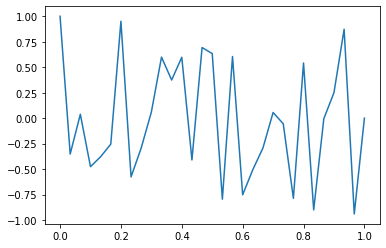


-------------------------------------
Theoretical best time: 0.5844480195427891 

iteration          0     |    loss: 5.6359
iteration         20     |    loss: 1.0114
iteration         40     |    loss: 0.6545
iteration         60     |    loss: 0.6541
iteration         80     |    loss: 0.6208
iteration        100     |    loss: 0.6171
iteration        120     |    loss: 0.6122
iteration        140     |    loss: 0.6098
iteration        160     |    loss: 0.6082
iteration        180     |    loss: 0.6050
iteration        200     |    loss: 0.6034
iteration        220     |    loss: 0.6015
iteration        240     |    loss: 0.5994
iteration        260     |    loss: 0.5984
iteration        280     |    loss: 0.5955
iteration        300     |    loss: 0.5982
iteration        320     |    loss: 0.5927
iteration        340     |    loss: 0.5944
iteration        360     |    loss: 0.5976
iteration        380     |    loss: 0.5895

-------------------------------------


<Figure size 432x288 with 0 Axes>

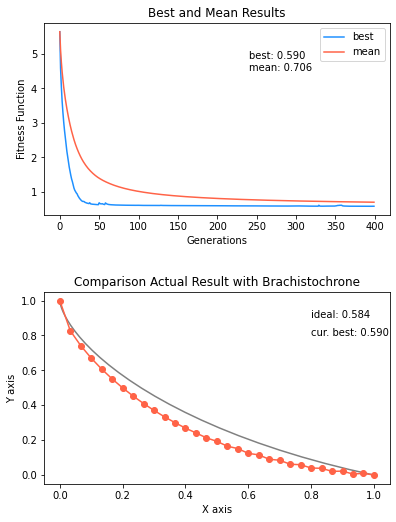

In [35]:
population = Population(Individual, n_individuals=1, n_points=n_points, height=height)
individual = population.population[0][0]

fitness = Fitness(population)
fitness.getBestCurve(individual)


y = torch.tensor(individual.y[1:-1], requires_grad=True)

adam_optimizer = optim.RMSprop([y])

best = []
mean = []

for t in range(n_generations):

    J = fitnessFunction(y, height)

    best.append(J.item())
    mean.append(np.mean(best))

    individual.y[1:-1] = y.detach().tolist()

    if save_gif:
        if t==0 or (t%max(1, int(n_generations/frames_gif))==0):
            plt.savefig(f'{gif_dir}/{t+1}.png')

    if show_info:
      if t%int(n_generations/20)==0:
        print('iteration {:10}     |    loss: {:.4f}'.format(t, J.item()))

    adam_optimizer.zero_grad()
    J.backward()
    adam_optimizer.step()


plt.savefig(f'{misc_runs_dir}.png')


if show_info:
  print('\n-------------------------------------')

  fig, axes = plt.subplots(2,1,figsize=(6,8))
  plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)
  ax_FF = axes[0]
  ax_state = axes[1]
  fitness.plotFitnessFunction(ax_FF, best, mean)
  fitness.plotState(individual, ax_state, width, height, color='tomato', plot_sol=True, plot_label=True)

  fig.canvas.draw()


if save_gif:
    fp_in = gif_dir + "/*.png"
    fp_out = gif_dir + f'/image{counter+1}.gif'
    makeImage(fp_in, fp_out)



## Population Random Generation

n_points=30__height=1
Population Edited Parameters: 
n_points=30__height=1
--------------------------------
Population Diagram: 
--------------------------------


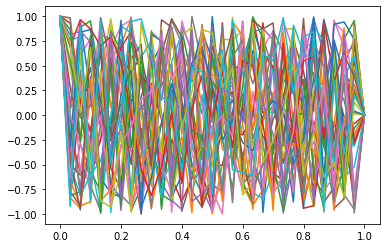


-------------------------------------
Objective Fitness 1:  Short Time


Individual          0     |    Fitness: 5.2716
Individual          1     |    Fitness: 5.0137
Individual          2     |    Fitness: 6.0392
Individual          3     |    Fitness: 5.5045
Individual          4     |    Fitness: 5.2312
Individual          5     |    Fitness: 5.7753
Individual          6     |    Fitness: 6.6800
Individual          7     |    Fitness: 4.8991
Individual          8     |    Fitness: 5.6398
Individual          9     |    Fitness: 4.8697
Individual         10     |    Fitness: 4.0931
Individual         11     |    Fitness: 3.8433
Individual         12     |    Fitness: 5.9304
Individual         13     |    Fitness: 4.5823
Individual         14     |    Fitness: 5.8085
Individual         15     |    Fitness: 5.6684
Individual         16     |    Fitness: 6.4732
Individual         17     |    Fitness: 4.4137
Individual         18     |    Fitness: 5.4296
Individual         19     |    Fi

In [43]:
population = Population(Individual, n_individuals, n_points=n_points, height=height)

GeneticAlgorithm(population=population, 
                 generations=n_generations,
                 variable=p_variable)


# Extra